<a href="https://colab.research.google.com/github/iguv221/Tobigs_Assignment/blob/main/6%EC%A3%BC%EC%B0%A8_NNAdv_%EA%B9%80%EC%84%B1%EC%9A%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5주차 과제 Neural Network Advanced 18기 김성우

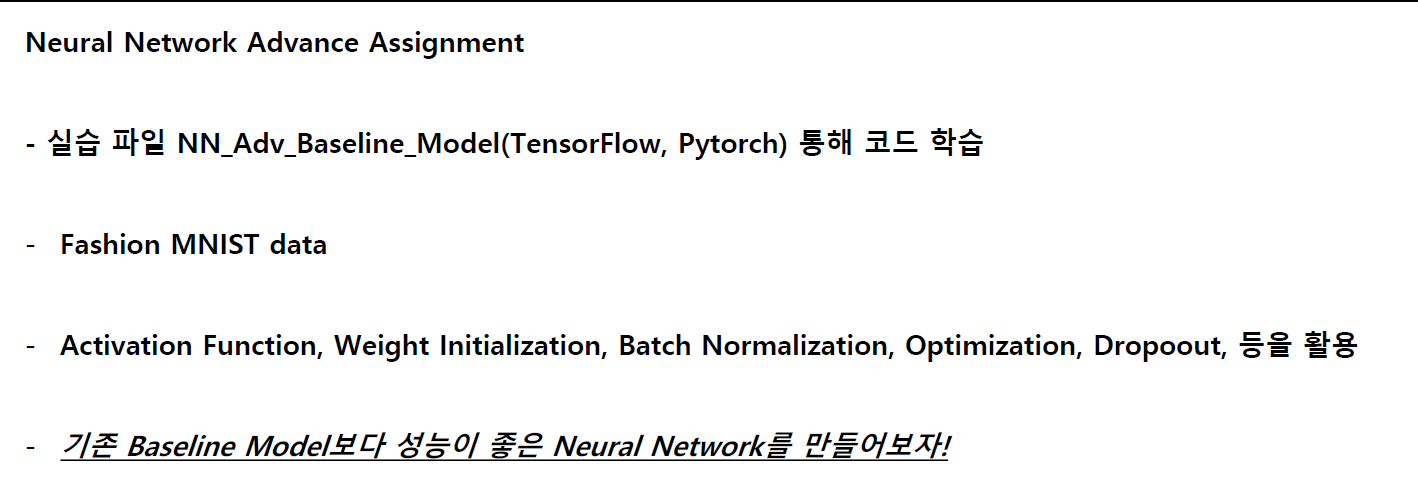

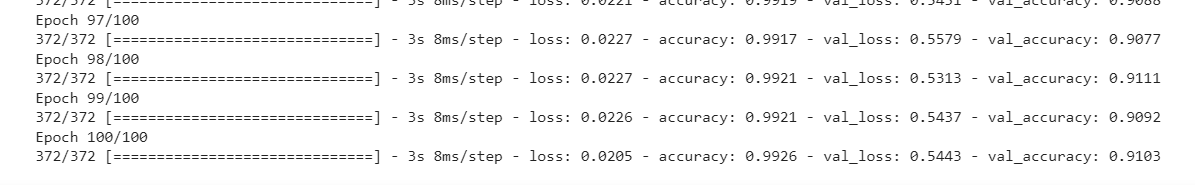

# 현재 Baseline Model 의 val accuracy 은 0.9103 
# 이보다 좋은 모델을 구현하도록 해보자.

# Step 1. Data Load and Exploration
### 데이터를 로드하고 어떻게 생겼는데, 몇 개 있는지 미리 알면 좋은 정보를 알아보는 단계이다.

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings(action='ignore')

In [64]:
train = pd.read_csv('/content/drive/MyDrive/ToBigs/과제 폴더/6주차/Train.csv')
test = pd.read_csv('/content/drive/MyDrive/ToBigs/과제 폴더/6주차/Test.csv')

In [65]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [66]:
train['label'].nunique()

10

In [67]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,67,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,2,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,93,58,78,45,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,71,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,63,0,0,0,0,0,0,0


In [68]:
X = train.iloc[:, :-1].values
y = train.iloc[:, -1].values

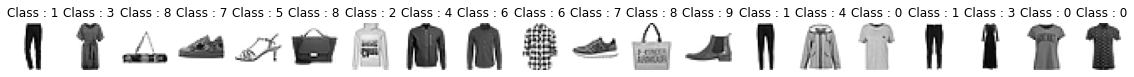

In [69]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

# FashionMNIST 이라는 데이터셋임을 알 수 있다.
### 보통 FashionMNIST 데이터셋은 torch.utils.datasets 에서 직접 다운로드 하는 것이 일반적이고 편리하지만, 이 과제에서는 따로 csv 파일을 만들어 주었기 때문에 이를 읽었다.
### FashionMNIST 은 train dataset 은 60000개, test dataset 은 10000개로 딥러닝 학습할때 자주 사용하는 데이터셋이다.

In [70]:
X_test = test.values

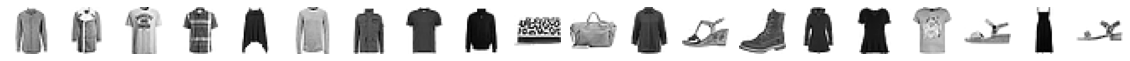

In [71]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

# Step 2. Data Preperation
### 이 단계에서는 필요한 패키지들 임포트, dataset 을 train 과 valid dataset 으로 나누고 tensor 으로 변환 및 dataloader 에 준비하는 과정을 거친다.

In [72]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LeakyReLU
from torch.nn import LogSoftmax
from torch.nn import Dropout
from torch import flatten

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [74]:

class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image
    else:
      image = self._image[idx]
      label = self._label[idx]
      return image, label

In [75]:
### Y Class, Target Class 가 총 몇 개인지 파악하기.
### 유동적인 모델 이용을 위한 조치.

num_classes = train['label'].nunique()
num_classes

10

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y, shuffle = True)

In [77]:
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

# 아래의 부분이 원래의 Baseline Model 과 차이를 이루게 하는 부분이다.
## Baseline Model 은 Fully Connected Layer 으로, Linear 하게 연산을 한다.
## 하지만 아래의 LeNet 모델을 Convolutional Network, 합연산 네트워크로 각 픽셀 값들과 그 주위값까지 고려하는 방식을 취한다.
## 대부분의 이미지 딥러닝에서 Convolutional Network 이 사용되는 이유는 이미지에서는 픽셀 값 자체도 중요하지만 픽셀과 그 주위의 값들의 관계를 파악하는 것도 중요하기 때문이다. Convolutional Network 은 filter 을 이용해 그 주위 관계까지 파악할 수 있다. 정형데이터(csv, excel) 에서는 이러한 관계가 크게 의미는 없지만 비정형데이터(image, sound) 에서는 앞뒤와 그 주위가 매우 중요하기 때문에 합연산 네트워크나 순환 네트워크가 fully connected layer 보다 더 자주 사용된다.
## 아래의 과제에서도 convolutional neural network 의 선조격인 LeNet(1998) 을 이용할 것이다. 그 이유는 계산과 시간의 한계(ㅎ) 와 fully connected newtork 과 convolutional network 의 차이 하나로 성능 개선이 이루어지는지, 이루어진다면 얼마나 이루어지는 등을 보고 싶어서이다.
## Convolutional Neural Network 에 접목을 시키기 위해서는 모든 data point 들을 정사각형 모양으로 바꿔줘야 한다.

In [78]:
X_train = X_train.resize(len(X_train),1,28,28)
X_val = X_val.resize(len(X_val),1,28,28)

# Step 3. Model Training
## 데이터로드까지 마무리했다면 모델을 학습시키면 된다.
## 아래의 train 과 evaluate 코드는 baseline code 에서 가져온 것으로, 너무 깔끔하게 잘 써져있어서 여기서 다시 사용하기로 했다.
## 그 아래의 LeNet_Original 은 인터넷에서 따라 친 코드이지만, 그 아래의 변형 버전들은 직접 생각 및 실험한 코드들로 여러 시행착오를 겪으며 더 좋은 성능을 내는 과정을 볼 수 있다. 
## 이때 수정하는 과정은 대부분 모델을 수정한 것이며, epoch, lr 과 같은 parameter 수정은 최후로 할 생각이다.

In [79]:
def train(model, train_loader):
    model.train()
    train_loss = 0
    correct = 0

    for image, label in train_loader:
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        prediction = output.max(1, keepdim = True)[1]
        correct += prediction.eq(label.view_as(prediction)).sum().item()
        
    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, train_accuracy

In [80]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

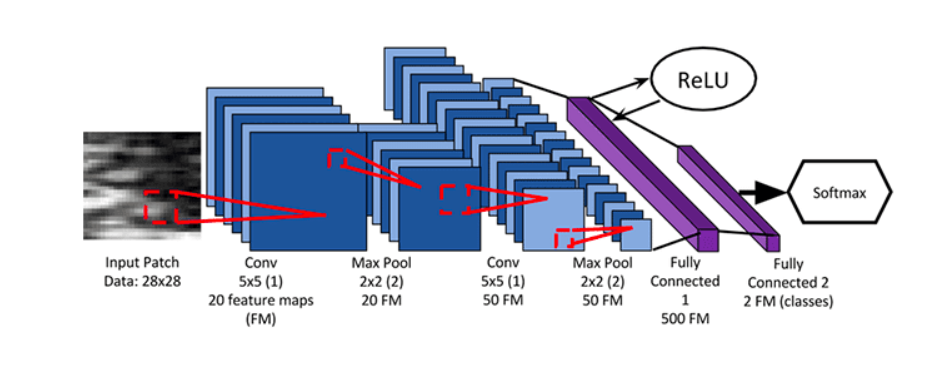

In [81]:
class LeNet_Original(Module):
    def __init__(self, numChannels, classes):
        super(LeNet_Original,self).__init__()

        self.relu = ReLU()
        self.maxpool = MaxPool2d(kernel_size = 2,stride = 2)

        self.conv1 = Conv2d(numChannels,20,kernel_size=5)
        self.conv2 = Conv2d(20,50,kernel_size=5)
        self.fc1 = Linear(800,500)
        self.fc2 = Linear(500,classes)
        self.logSoftmax = LogSoftmax(dim=1)

    def forward(self,x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = flatten(x,1)
        
        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.relu(x)
        
        return self.logSoftmax(x)

In [82]:
#########

lr = 0.0005
batch_size = 128
epochs = 20

train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = DataSet(X_val, y_val)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

#########

### Original Lenet Model

model_Original = LeNet_Original(numChannels = 1, classes = num_classes).to(device)
optimizer = torch.optim.SGD(model_Original.parameters(), lr = lr, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

result_list = []
for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(model_Original, train_loader)
    val_loss, val_accuracy = evaluate(model_Original, test_loader)
    print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
    result = {
        'EPOCH': epoch,
        'Train Loss': train_loss,
        'Train Accuracy': train_accuracy,
        'Val Loss': val_loss,
        'Val Accuracy': val_accuracy}
    
    result_list.append(result)

result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 1.8710, 	Train Accuracy: 28.39 %, 	Val Loss: 1.7722, 	Val Accuracy: 29.39 % 

[EPOCH: 2], 	Train Loss: 1.7385, 	Train Accuracy: 30.48 %, 	Val Loss: 1.5720, 	Val Accuracy: 38.03 % 

[EPOCH: 3], 	Train Loss: 1.4992, 	Train Accuracy: 43.01 %, 	Val Loss: 1.4441, 	Val Accuracy: 46.63 % 

[EPOCH: 4], 	Train Loss: 1.4134, 	Train Accuracy: 47.25 %, 	Val Loss: 1.4005, 	Val Accuracy: 47.40 % 

[EPOCH: 5], 	Train Loss: 1.3874, 	Train Accuracy: 47.53 %, 	Val Loss: 1.3887, 	Val Accuracy: 47.35 % 

[EPOCH: 6], 	Train Loss: 1.3724, 	Train Accuracy: 47.79 %, 	Val Loss: 1.3746, 	Val Accuracy: 47.57 % 

[EPOCH: 7], 	Train Loss: 1.2453, 	Train Accuracy: 53.90 %, 	Val Loss: 1.2041, 	Val Accuracy: 56.03 % 

[EPOCH: 8], 	Train Loss: 1.1810, 	Train Accuracy: 56.46 %, 	Val Loss: 1.1981, 	Val Accuracy: 56.10 % 

[EPOCH: 9], 	Train Loss: 1.1661, 	Train Accuracy: 56.70 %, 	Val Loss: 1.1811, 	Val Accuracy: 56.46 % 

[EPOCH: 10], 	Train Loss: 1.1569, 	Train Accuracy: 56.82 %, 	Val Loss: 1.

# Original LeNet Model 은 기대 이하의 성능을 보이고 있다.
## 아무리 간단하고 초창기 모델이라 해도 흑백의 1개 channel 인 이미지 다루는데 10개 클래스에서 56% 의 정확도는 너무 안 좋다.
## 일단 먼저 고쳐보고 싶은 점은 fully connected layer 부분에서 800->500->10 으로 줄이는 부분이다. 500에서 10으로 한 단계만에 줄이기에는 너무 많은 data loss 가 발생하지 않나 라는 생각으로 중간에 하나의 fully connected layer 을 추가해봤다. 그것이 아래의 LeNet_2 이고 800->500->200->10 읜 순서대로 이어졌다.

In [83]:
class LeNet_2(Module):
    def __init__(self, numChannels, classes):
        super(LeNet_2,self).__init__()

        self.relu = ReLU()
        self.maxpool = MaxPool2d(kernel_size = 2,stride = 2)

        self.conv1 = Conv2d(numChannels,20,kernel_size=5)
        self.conv2 = Conv2d(20,50,kernel_size=5)
        self.fc1 = Linear(800,500)
        self.fc2 = Linear(500,200)
        self.fc3 = Linear(200,classes) # NEW LINE
        self.logSoftmax = LogSoftmax(dim=1)


    def forward(self,x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = flatten(x,1)
        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.relu(x)

        x = self.fc3(x) # NEW LINE
        x = self.relu(x) # NEW LINE
                
        return self.logSoftmax(x)

In [84]:
#########

lr = 0.0005
batch_size = 128
epochs = 20

train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = DataSet(X_val, y_val)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

#########


model_2 = LeNet_2(numChannels = 1, classes = num_classes).to(device)
optimizer = torch.optim.SGD(model_2.parameters(), lr = lr, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

result_list = []
for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(model_2, train_loader)
    val_loss, val_accuracy = evaluate(model_2, test_loader)
    print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
    result = {
        'EPOCH': epoch,
        'Train Loss': train_loss,
        'Train Accuracy': train_accuracy,
        'Val Loss': val_loss,
        'Val Accuracy': val_accuracy}
    
    result_list.append(result)

result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 1.4015, 	Train Accuracy: 51.79 %, 	Val Loss: 1.2879, 	Val Accuracy: 53.78 % 

[EPOCH: 2], 	Train Loss: 1.2666, 	Train Accuracy: 54.48 %, 	Val Loss: 1.2524, 	Val Accuracy: 54.61 % 

[EPOCH: 3], 	Train Loss: 1.2376, 	Train Accuracy: 55.08 %, 	Val Loss: 1.2218, 	Val Accuracy: 55.24 % 

[EPOCH: 4], 	Train Loss: 1.2187, 	Train Accuracy: 55.51 %, 	Val Loss: 1.2386, 	Val Accuracy: 55.08 % 

[EPOCH: 5], 	Train Loss: 1.2049, 	Train Accuracy: 55.80 %, 	Val Loss: 1.2131, 	Val Accuracy: 55.54 % 

[EPOCH: 6], 	Train Loss: 1.1947, 	Train Accuracy: 55.95 %, 	Val Loss: 1.2086, 	Val Accuracy: 55.31 % 

[EPOCH: 7], 	Train Loss: 1.1859, 	Train Accuracy: 56.22 %, 	Val Loss: 1.1948, 	Val Accuracy: 55.87 % 

[EPOCH: 8], 	Train Loss: 1.1793, 	Train Accuracy: 56.24 %, 	Val Loss: 1.1977, 	Val Accuracy: 55.99 % 

[EPOCH: 9], 	Train Loss: 1.1721, 	Train Accuracy: 56.45 %, 	Val Loss: 1.1845, 	Val Accuracy: 55.82 % 

[EPOCH: 10], 	Train Loss: 1.1656, 	Train Accuracy: 56.53 %, 	Val Loss: 1.

# LeNet_2 은 70% 의 정확도로, LeNet Original 에 비해 많이 개선된 모습을 보여줬다. 하지만 90% 에 도달하기에 아직 멀었다.
## 다음 모델 Lenet_3 에는 dropout 을 접목을 시켜봤다. Dropout percentage 으로 0.2 가 많이 채택되기에 이대로 가져갔고 convolution layer 뒤에는 추가하되 fully connected layer 뒤에는 추가하지 않았다. 그 이유는 convolutional layer 들이 픽셀 수가 훨씬 많은데다 옷 이미지 특성상 주위가 다 검을 확률이 많기 때문에 이러한 픽셀들은 버리는게 유리할 것이다. 하지만 fully connected layer 들은 latent feature 을 뽑아오기 때문에 중요한 픽셀들만 남길텐데 이 픽셀들을 랜덤하게 버리면 오히려 정확도가 떨어질 수 있다.

In [85]:
class LeNet_3(Module):
    def __init__(self, numChannels, classes):
        super(LeNet_3,self).__init__()

        self.relu = ReLU()
        self.maxpool = MaxPool2d(kernel_size = 2,stride = 2)
        self.dropout = Dropout(p=0.2) # NEW LINE

        self.conv1 = Conv2d(numChannels,20,kernel_size=5)
        self.conv2 = Conv2d(20,50,kernel_size=5)
        self.fc1 = Linear(800,500)
        self.fc2 = Linear(500,200)
        self.fc3 = Linear(200,classes)
        self.logSoftmax = LogSoftmax(dim=1)

    def forward(self,x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x) 
        x = self.dropout(x) # NEW LINE

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x) # NEW LINE

        x = flatten(x,1)
        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.relu(x)

        x = self.fc3(x)
        x = self.relu(x)
    
        return self.logSoftmax(x)

In [86]:
#########

lr = 0.0005
batch_size = 128
epochs = 20

train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = DataSet(X_val, y_val)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

#########


model_3 = LeNet_3(numChannels = 1, classes = num_classes).to(device)
optimizer = torch.optim.SGD(model_3.parameters(), lr = lr, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

result_list = []
for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(model_3, train_loader)
    val_loss, val_accuracy = evaluate(model_3, test_loader)
    print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
    result = {
        'EPOCH': epoch,
        'Train Loss': train_loss,
        'Train Accuracy': train_accuracy,
        'Val Loss': val_loss,
        'Val Accuracy': val_accuracy}
    
    result_list.append(result)

result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 1.9371, 	Train Accuracy: 32.71 %, 	Val Loss: 1.5167, 	Val Accuracy: 50.04 % 

[EPOCH: 2], 	Train Loss: 1.4727, 	Train Accuracy: 50.98 %, 	Val Loss: 1.3207, 	Val Accuracy: 54.52 % 

[EPOCH: 3], 	Train Loss: 1.3036, 	Train Accuracy: 55.05 %, 	Val Loss: 1.0585, 	Val Accuracy: 61.76 % 

[EPOCH: 4], 	Train Loss: 1.0674, 	Train Accuracy: 61.31 %, 	Val Loss: 0.8110, 	Val Accuracy: 72.18 % 

[EPOCH: 5], 	Train Loss: 0.8361, 	Train Accuracy: 70.07 %, 	Val Loss: 0.7382, 	Val Accuracy: 73.67 % 

[EPOCH: 6], 	Train Loss: 0.7822, 	Train Accuracy: 71.48 %, 	Val Loss: 0.7121, 	Val Accuracy: 74.15 % 

[EPOCH: 7], 	Train Loss: 0.7512, 	Train Accuracy: 72.57 %, 	Val Loss: 0.6822, 	Val Accuracy: 75.20 % 

[EPOCH: 8], 	Train Loss: 0.7285, 	Train Accuracy: 73.16 %, 	Val Loss: 0.6639, 	Val Accuracy: 76.19 % 

[EPOCH: 9], 	Train Loss: 0.7094, 	Train Accuracy: 73.83 %, 	Val Loss: 0.6516, 	Val Accuracy: 76.55 % 

[EPOCH: 10], 	Train Loss: 0.6946, 	Train Accuracy: 74.38 %, 	Val Loss: 0.

# LeNet_3 에서 Dropout 을 이용해 87% 의 valid accuracy 를 보이며 더 향상된 성능을 보임을 알 수 있다.
##  한 가지 실험해보고 싶은 것은 활성화 함수의 변경이다. 물론 ReLU 가 좋은 활성화 함수이지만, 최근에는 ReLU 보다 LeakyReLU 를 더 사용하는 분위기이다. ReLU 와 LeakyReLU 의 차이는 ReLU 는 활성화 시키지 않을 시 아예 0 을 내보내지만 LeakyReLU 은 0보다 아주 조금 큰 양수를 내보낸다. 말 그대로 'leaky', '샌다' 의 뜻이다. 간단한 모델인 LeNet 에서 큰 영향을 끼치지 않을 것 같지만 그래도 이 활성화 함수의 차이가 성능에 어떠한 영향을 미칠지 알아보기 위해 LeNet_4 를 구성했다.


In [87]:
class LeNet_4(Module):
    def __init__(self, numChannels, classes):
        super(LeNet_4,self).__init__()

        self.leakyrelu = LeakyReLU() # Modified ReLU() to LeakyReLU() 
        self.maxpool = MaxPool2d(kernel_size = 2,stride = 2)
        self.dropout = Dropout(p=0.2)

        self.conv1 = Conv2d(numChannels,20,kernel_size=5)
        self.conv2 = Conv2d(20,50,kernel_size=5)
        self.fc1 = Linear(800,500)
        self.fc2 = Linear(500,200)
        self.fc3 = Linear(200,classes)
        self.logSoftmax = LogSoftmax(dim=1)

    def forward(self,x):
        x = self.conv1(x)
        x = self.leakyrelu(x) # Modified ReLU() to LeakyReLU() 
        x = self.maxpool(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.leakyrelu(x) # Modified ReLU() to LeakyReLU() 
        x = self.maxpool(x)
        x = self.dropout(x)

        x = flatten(x,1)
        x = self.fc1(x)
        x = self.leakyrelu(x) # Modified ReLU() to LeakyReLU() 

        x = self.fc2(x)
        x = self.leakyrelu(x) # Modified ReLU() to LeakyReLU() 

        x = self.fc3(x)
        x = self.leakyrelu(x) # Modified ReLU() to LeakyReLU() 
                
        return self.logSoftmax(x)

In [88]:
#########

lr = 0.0005
batch_size = 128
epochs = 20

train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = DataSet(X_val, y_val)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

#########

model_4 = LeNet_4(numChannels = 1, classes = num_classes).to(device)
optimizer = torch.optim.SGD(model_4.parameters(), lr = lr, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

result_list = []
for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(model_4, train_loader)
    val_loss, val_accuracy = evaluate(model_4, test_loader)
    print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
    result = {
        'EPOCH': epoch,
        'Train Loss': train_loss,
        'Train Accuracy': train_accuracy,
        'Val Loss': val_loss,
        'Val Accuracy': val_accuracy}
    
    result_list.append(result)

result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 1.5820, 	Train Accuracy: 46.21 %, 	Val Loss: 0.8306, 	Val Accuracy: 72.45 % 

[EPOCH: 2], 	Train Loss: 0.7627, 	Train Accuracy: 71.90 %, 	Val Loss: 0.6064, 	Val Accuracy: 78.66 % 

[EPOCH: 3], 	Train Loss: 0.6387, 	Train Accuracy: 76.35 %, 	Val Loss: 0.5474, 	Val Accuracy: 80.55 % 

[EPOCH: 4], 	Train Loss: 0.5812, 	Train Accuracy: 78.54 %, 	Val Loss: 0.5060, 	Val Accuracy: 81.41 % 

[EPOCH: 5], 	Train Loss: 0.5445, 	Train Accuracy: 79.87 %, 	Val Loss: 0.4768, 	Val Accuracy: 82.82 % 

[EPOCH: 6], 	Train Loss: 0.5184, 	Train Accuracy: 81.03 %, 	Val Loss: 0.4546, 	Val Accuracy: 83.79 % 

[EPOCH: 7], 	Train Loss: 0.4978, 	Train Accuracy: 81.86 %, 	Val Loss: 0.4331, 	Val Accuracy: 84.81 % 

[EPOCH: 8], 	Train Loss: 0.4808, 	Train Accuracy: 82.49 %, 	Val Loss: 0.4224, 	Val Accuracy: 85.02 % 

[EPOCH: 9], 	Train Loss: 0.4702, 	Train Accuracy: 82.95 %, 	Val Loss: 0.4118, 	Val Accuracy: 85.49 % 

[EPOCH: 10], 	Train Loss: 0.4571, 	Train Accuracy: 83.42 %, 	Val Loss: 0.

# LeNet_4 에서 ReLU 을 LeakyReLU 로 바꾼 결과 성능이 거의 변하지 않았음을 확인할 수 있다. 이러한 사소한 활성화 함수의 차이는 순환신경망에서는 큰 차이로 이어질 수는 있어도 합성곱 신경망(그것도 꽤나 간단한)에서는 그러지 않은 모양이다.
## LeNet_5 에는 LeNet_4 모델에 drouput의 p 를 0.2 에서 0.1 로 줄여본다. 또한 파라미터만 수정을 해볼 것이다. epoch 수를 20 에서 100으로 대폭 늘려보고 Learning Rate 도 0.0005 에서 0.001 로 늘려본다. 이 값들은 baseline model 의 파라미터들을 그대로 가져온 것이다.

In [89]:
class LeNet_5(Module):
    def __init__(self, numChannels, classes):
        super(LeNet_5,self).__init__()

        self.leakyrelu = LeakyReLU()
        self.maxpool = MaxPool2d(kernel_size = 2,stride = 2)
        self.dropout = Dropout(p=0.1)  # 0.2 to 0.1

        self.conv1 = Conv2d(numChannels,20,kernel_size=5)
        self.conv2 = Conv2d(20,50,kernel_size=5)
        self.fc1 = Linear(800,500)
        self.fc2 = Linear(500,classes)
        self.logSoftmax = LogSoftmax(dim=1)

    def forward(self,x):
        x = self.conv1(x)
        x = self.leakyrelu(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.leakyrelu(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        x = flatten(x,1)
        x = self.fc1(x)
        x = self.leakyrelu(x)

        x = self.fc2(x)
        x = self.leakyrelu(x)

        return self.logSoftmax(x)

In [61]:
#########

lr = 0.001 # 0.0005 to 0.001
batch_size = 128
epochs = 100 # 20 to 100

train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = DataSet(X_val, y_val)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

#########

model_5 = LeNet_5(numChannels = 1, classes = num_classes).to(device)
optimizer = torch.optim.SGD(model_5.parameters(), lr = lr, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

result_list = []
for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(model_5, train_loader)
    val_loss, val_accuracy = evaluate(model_5, test_loader)
    print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
    result = {
        'EPOCH': epoch,
        'Train Loss': train_loss,
        'Train Accuracy': train_accuracy,
        'Val Loss': val_loss,
        'Val Accuracy': val_accuracy}
    
    result_list.append(result)

result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 1.9149, 	Train Accuracy: 34.86 %, 	Val Loss: 0.8962, 	Val Accuracy: 67.67 % 

[EPOCH: 2], 	Train Loss: 0.8234, 	Train Accuracy: 69.96 %, 	Val Loss: 0.6944, 	Val Accuracy: 74.41 % 

[EPOCH: 3], 	Train Loss: 0.6724, 	Train Accuracy: 75.63 %, 	Val Loss: 0.4438, 	Val Accuracy: 84.68 % 

[EPOCH: 4], 	Train Loss: 0.4538, 	Train Accuracy: 83.83 %, 	Val Loss: 0.3986, 	Val Accuracy: 86.24 % 

[EPOCH: 5], 	Train Loss: 0.4177, 	Train Accuracy: 85.17 %, 	Val Loss: 0.3746, 	Val Accuracy: 86.82 % 

[EPOCH: 6], 	Train Loss: 0.3938, 	Train Accuracy: 86.00 %, 	Val Loss: 0.3597, 	Val Accuracy: 87.32 % 

[EPOCH: 7], 	Train Loss: 0.3771, 	Train Accuracy: 86.53 %, 	Val Loss: 0.3572, 	Val Accuracy: 87.53 % 

[EPOCH: 8], 	Train Loss: 0.3614, 	Train Accuracy: 87.01 %, 	Val Loss: 0.3474, 	Val Accuracy: 87.72 % 

[EPOCH: 9], 	Train Loss: 0.3500, 	Train Accuracy: 87.58 %, 	Val Loss: 0.3419, 	Val Accuracy: 87.75 % 

[EPOCH: 10], 	Train Loss: 0.3389, 	Train Accuracy: 87.85 %, 	Val Loss: 0.

# LeNet_5 에서 드디어 baseline model 과 견주는 모델이 나왔다. 원래 baseline model 은 기초 모델인데 이를 능가하는데 생각보다 손을 많이 쓰긴 했다. 
## 여기서 한 가지 체크할 부분은 dropout 을 0.2 에서 0.1 로 줄였는데 epoch 20 에서 더 좋은 성능을 보였다는 것이다. 따라서 dropout 은 0.1 로 계속 이어간다. 또 한가지 체크할 부분은 epoch 100 에서 train accuracy 은 95 언저리지만 val accuracy 은 91 이다. 이는 과적합이 거의 안 되었다고 생각할 수 있기 때문에 새로운 데이터에서도 좋은 성능을 기대할 수 있다.

# 우선 모델 개선은 여기까지 하고, learning rate 와 batch size parameter tuning 을 진행해 좋은 parameter 을 찾아보도록 하자.
## 이때 parameter tuning 하는 방법으로 크게 grid parameter tuning 과 random parameter tuning 이 있는데 여기서는 grid parameter tuning 을 진행할 것이다.

In [92]:
class LeNet_Final(Module):
    def __init__(self, numChannels, classes):
        super(LeNet_Final,self).__init__()

        self.leakyrelu = LeakyReLU()
        self.maxpool = MaxPool2d(kernel_size = 2,stride = 2)
        self.dropout = Dropout(p=0.1)  # 0.2 to 0.1

        self.conv1 = Conv2d(numChannels,20,kernel_size=5)
        self.conv2 = Conv2d(20,50,kernel_size=5)
        self.fc1 = Linear(800,500)
        self.fc2 = Linear(500,classes)
        self.logSoftmax = LogSoftmax(dim=1)

    def forward(self,x):
        x = self.conv1(x)
        x = self.leakyrelu(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.leakyrelu(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        x = flatten(x,1)
        x = self.fc1(x)
        x = self.leakyrelu(x)

        x = self.fc2(x)
        x = self.leakyrelu(x)

        return self.logSoftmax(x)

In [94]:
#########

# First Parameter Tuning
# 처음에는 LR 와 Batch_size 의 폭을 넓게 잡아 좋은 성능 내는 곳을 빠르게 찾아본다.
# 또한 실제 성능 값보다 비교가 더 중요하기 때문에 epoch 수를 100에서 50으로 줄여 학습 시간을 단축한다.

LR = [0.0001,0.001,0.01]
BATCH_SIZE = [64,256,512]
epoch = 50

#########

for lr in LR:
    for batch_size in BATCH_SIZE:
        print("Running Test with LR : {} and Batch_Size : {}".format(lr,batch_size))
        train_dataset = DataSet(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

        test_dataset = DataSet(X_val, y_val)
        test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

        model_Final = LeNet_Final(numChannels = 1, classes = num_classes).to(device)
        optimizer = torch.optim.SGD(model_Final.parameters(), lr = lr, momentum = 0.5)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(1, epochs + 1):
            train_loss, train_accuracy = train(model_Final, train_loader)
            val_loss, val_accuracy = evaluate(model_Final, test_loader)

        print(f"Train Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")



Running Test with LR : 0.0001 and Batch_Size : 64
Train Loss: 0.4046, 	Train Accuracy: 85.60 %, 	Val Loss: 0.3690, 	Val Accuracy: 87.13 % 

Running Test with LR : 0.0001 and Batch_Size : 256
Train Loss: 0.5844, 	Train Accuracy: 78.63 %, 	Val Loss: 0.5228, 	Val Accuracy: 80.69 % 

Running Test with LR : 0.0001 and Batch_Size : 512
Train Loss: 0.6275, 	Train Accuracy: 77.31 %, 	Val Loss: 0.5412, 	Val Accuracy: 80.69 % 

Running Test with LR : 0.001 and Batch_Size : 64
Train Loss: 0.2632, 	Train Accuracy: 90.42 %, 	Val Loss: 0.2898, 	Val Accuracy: 89.30 % 

Running Test with LR : 0.001 and Batch_Size : 256
Train Loss: 0.3657, 	Train Accuracy: 86.87 %, 	Val Loss: 0.3398, 	Val Accuracy: 87.69 % 

Running Test with LR : 0.001 and Batch_Size : 512
Train Loss: 0.4100, 	Train Accuracy: 85.14 %, 	Val Loss: 0.3740, 	Val Accuracy: 86.78 % 

Running Test with LR : 0.01 and Batch_Size : 64
Train Loss: nan, 	Train Accuracy: 10.00 %, 	Val Loss: nan, 	Val Accuracy: 10.00 % 

Running Test with LR : 0.01

In [95]:
#########

# Second Parameter Tuning
# 우선 위의 tuning 결과를 보아 learning rate 은 0.001 사이가 적당해 보이고 batch size 은 64 주위가 적당해 보인다.
# 이번 tuning test 에는 그 언저리를 실험해본다.

LR = [0.0005,0.001,0.0015]
BATCH_SIZE = [32,64,128]
epoch = 50

#########

for lr in LR:
    for batch_size in BATCH_SIZE:
        print("Running Test with LR : {} and Batch_Size : {}".format(lr,batch_size))
        train_dataset = DataSet(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

        test_dataset = DataSet(X_val, y_val)
        test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

        model_Final = LeNet_Final(numChannels = 1, classes = num_classes).to(device)
        optimizer = torch.optim.SGD(model_Final.parameters(), lr = lr, momentum = 0.5)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(1, epochs + 1):
            train_loss, train_accuracy = train(model_Final, train_loader)
            val_loss, val_accuracy = evaluate(model_Final, test_loader)

        print(f"Train Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")



Running Test with LR : 0.0005 and Batch_Size : 32
Train Loss: 0.2382, 	Train Accuracy: 91.22 %, 	Val Loss: 0.2709, 	Val Accuracy: 90.24 % 

Running Test with LR : 0.0005 and Batch_Size : 64
Train Loss: 0.2888, 	Train Accuracy: 89.64 %, 	Val Loss: 0.3024, 	Val Accuracy: 89.12 % 

Running Test with LR : 0.0005 and Batch_Size : 128
Train Loss: 0.3147, 	Train Accuracy: 88.76 %, 	Val Loss: 0.3128, 	Val Accuracy: 88.93 % 

Running Test with LR : 0.001 and Batch_Size : 32
Train Loss: 0.2033, 	Train Accuracy: 92.52 %, 	Val Loss: 0.2604, 	Val Accuracy: 90.76 % 

Running Test with LR : 0.001 and Batch_Size : 64
Train Loss: 0.2490, 	Train Accuracy: 90.89 %, 	Val Loss: 0.2711, 	Val Accuracy: 90.15 % 

Running Test with LR : 0.001 and Batch_Size : 128
Train Loss: 0.3079, 	Train Accuracy: 88.88 %, 	Val Loss: 0.3045, 	Val Accuracy: 89.18 % 

Running Test with LR : 0.0015 and Batch_Size : 32
Train Loss: 0.1992, 	Train Accuracy: 92.40 %, 	Val Loss: 0.2751, 	Val Accuracy: 90.24 % 

Running Test with LR 

# batch size 가 작고, learning rate 은 0.001 이 제일 적당해 보인다. 이를 여러번 실험을 해 일반적으로 좋은 결과를 내는 모델인지 확인을 해본다.

In [96]:
#########

# Third Parameter Tuning.
## Testing the model to see if it shows stable results.

LR = [0.001,0.001,0.001]
BATCH_SIZE = [32,32,32]
epoch = 100

#########

for lr in LR:
    for batch_size in BATCH_SIZE:
        print("Running Test with LR : {} and Batch_Size : {}".format(lr,batch_size))
        train_dataset = DataSet(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

        test_dataset = DataSet(X_val, y_val)
        test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

        model_Final = LeNet_Final(numChannels = 1, classes = num_classes).to(device)
        optimizer = torch.optim.SGD(model_Final.parameters(), lr = lr, momentum = 0.5)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(1, epochs + 1):
            train_loss, train_accuracy = train(model_Final, train_loader)
            val_loss, val_accuracy = evaluate(model_Final, test_loader)

        print(f"Train Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")



Running Test with LR : 0.001 and Batch_Size : 32
Train Loss: 0.2049, 	Train Accuracy: 92.41 %, 	Val Loss: 0.2708, 	Val Accuracy: 90.33 % 

Running Test with LR : 0.001 and Batch_Size : 32
Train Loss: 0.1933, 	Train Accuracy: 92.78 %, 	Val Loss: 0.2676, 	Val Accuracy: 90.64 % 

Running Test with LR : 0.001 and Batch_Size : 32
Train Loss: 0.4092, 	Train Accuracy: 85.26 %, 	Val Loss: 0.3823, 	Val Accuracy: 86.50 % 

Running Test with LR : 0.001 and Batch_Size : 32
Train Loss: 0.2098, 	Train Accuracy: 92.22 %, 	Val Loss: 0.2689, 	Val Accuracy: 90.44 % 

Running Test with LR : 0.001 and Batch_Size : 32
Train Loss: 0.2020, 	Train Accuracy: 92.41 %, 	Val Loss: 0.2748, 	Val Accuracy: 89.84 % 

Running Test with LR : 0.001 and Batch_Size : 32
Train Loss: 0.2160, 	Train Accuracy: 91.90 %, 	Val Loss: 0.2719, 	Val Accuracy: 90.10 % 

Running Test with LR : 0.001 and Batch_Size : 32
Train Loss: 0.1896, 	Train Accuracy: 92.99 %, 	Val Loss: 0.2609, 	Val Accuracy: 90.81 % 

Running Test with LR : 0.00

# 안정적으로 90 언저리의 정확도를 내는 것을 확인할 수 있다.

# 최종 모델의 Parameter
# Learning Rate : 0.001 
# Batch Size : 32

# 마지막 결과 확인용


In [99]:
#########

lr = 0.001 
batch_size = 32
epochs = 50 

train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = DataSet(X_val, y_val)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

#########

model_Final = LeNet_Final(numChannels = 1, classes = num_classes).to(device)
optimizer = torch.optim.SGD(model_Final.parameters(), lr = lr, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

result_list = []
for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(model_Final, train_loader)
    val_loss, val_accuracy = evaluate(model_Final, test_loader)
    print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
    result = {
        'EPOCH': epoch,
        'Train Loss': train_loss,
        'Train Accuracy': train_accuracy,
        'Val Loss': val_loss,
        'Val Accuracy': val_accuracy}
    
    result_list.append(result)

result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 1.1059, 	Train Accuracy: 63.98 %, 	Val Loss: 0.6449, 	Val Accuracy: 81.34 % 

[EPOCH: 2], 	Train Loss: 0.4574, 	Train Accuracy: 83.84 %, 	Val Loss: 0.3742, 	Val Accuracy: 86.82 % 

[EPOCH: 3], 	Train Loss: 0.3869, 	Train Accuracy: 86.03 %, 	Val Loss: 0.3538, 	Val Accuracy: 87.32 % 

[EPOCH: 4], 	Train Loss: 0.3560, 	Train Accuracy: 87.07 %, 	Val Loss: 0.3305, 	Val Accuracy: 88.08 % 

[EPOCH: 5], 	Train Loss: 0.3348, 	Train Accuracy: 87.86 %, 	Val Loss: 0.3198, 	Val Accuracy: 88.65 % 

[EPOCH: 6], 	Train Loss: 0.3183, 	Train Accuracy: 88.33 %, 	Val Loss: 0.3139, 	Val Accuracy: 88.65 % 

[EPOCH: 7], 	Train Loss: 0.3012, 	Train Accuracy: 89.00 %, 	Val Loss: 0.2998, 	Val Accuracy: 88.86 % 

[EPOCH: 8], 	Train Loss: 0.2905, 	Train Accuracy: 89.20 %, 	Val Loss: 0.2941, 	Val Accuracy: 89.50 % 

[EPOCH: 9], 	Train Loss: 0.2799, 	Train Accuracy: 89.64 %, 	Val Loss: 0.2873, 	Val Accuracy: 89.74 % 

[EPOCH: 10], 	Train Loss: 0.2725, 	Train Accuracy: 89.95 %, 	Val Loss: 0.

# 정리.
## 1. Lenet Original 모델 형식은 convolutional network 초기를 보여주는 모델로 지금은 많은 발전이 이루어진 영역이다.
## 2. Fully Connected Layer 이 너무 급격하게 줄어드는 부분이 있으면 한 layer 더 추가해서 정보 손실량을 줄이는 것도 고려해야 한다.
## 3. Dropout 과 다양한 dropout probability p 를 이용해 과적합이 덜 일어나는 모델을 찾는 것도 중요하다.
## 4. 다양한 활성화 함수를 사용해 좋은 성능을 내는 활성화 함수를 찾자.
## 5. 최종 모델을 확정 지었으면 여러 parameter tuning 을 진행해 좋은 parameter 을 찾도록 하자.


